# Segment & Cluster Toronto Neighborhoods

__Objective__:
- Previously, we have succeeded to retrieve the latitude and longitude coordinate in `Pre2_Coordinate_Retrieval.ipynb`notebook file. 


- Now, we will __explore__, __segment__, and __group neighborhoods__ into clusters to find similar neighborhoods in __Toronto City__.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from tqdm import tqdm
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
import json
from pandas import json_normalize
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

pd.set_option('display.max_columns', None)

### Load Data

In [2]:
toronto_df = pd.read_csv('/Users/mac/Desktop/DataScience/Pojects_ds/coffee_shop/dataset/toronto_poscode_latlng.csv')
toronto_df.head()

,PostalCode,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


In [3]:
toronto_df.shape

(103, 5)

In [4]:
len(toronto_df['Neighbourhood'].unique())

99

We can see that there are moe than 1 neighborhood for one postal code. Lets see how many postalcodes(neighborhoods, treating each postal as a neighborhood) and borough we got.

In [5]:
print('The dataframe has {} boroughs and {} postal codes.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 postal codes.


## Map: Toronto & Neighborhoods

In [6]:
#getting lat, long values of tornoto to make a map
address = 'Toronto, Ontario'

#define a unique user_agent
geolocator = Nominatim(user_agent = 'toronto_explorer')

# Retrieve Toronto coordinate
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [8]:
#create map of Toronto using lat and long values
map_toronto = folium.Map(location=[latitude,longitude], zoom_start=10.5)

#add markers to map
for lat, long, borough, neighborhood in zip(toronto_df['latitude'], toronto_df['longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,long],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity=0.7,
        parse_html = False
    ).add_to(map_toronto)
    
map_toronto

## Map: A Borough and Neighborhoods
We will pick boroughs that contain _'toronto'_ name in it.
Let's see what boroughs those are:

In [9]:
toronto_df.groupby('Borough').count().sort_values(by = 'Neighbourhood', ascending = False)

,PostalCode,Neighbourhood,latitude,longitude
Borough,,,,
North York,24,24,24,24
Downtown Toronto,19,19,19,19
Scarborough,17,17,17,17
Etobicoke,12,12,12,12
Central Toronto,9,9,9,9
West Toronto,6,6,6,6
East Toronto,5,5,5,5
East York,5,5,5,5
York,5,5,5,5


Say you currently live at _Northwest_, __Etobicoke__, and you got a new job at __Downtown Toronto__. You want to move there but trying to find a settlement as the same as your current neighborhood.

We will name it __`downtown_df`__ dataframe to rerpresent all neghborhoods containing both boroughs.

In [10]:
downtown_df = toronto_df[toronto_df['Borough'].str.contains('Toronto') == True].reset_index()
downtown_df = toronto_df[(toronto_df['Borough']=='Downtown Toronto') | (toronto_df['Borough']=='Etobicoke')].reset_index(drop=True)

boroughs_df = toronto_df[(toronto_df['Borough']=='Central Toronto') | (toronto_df['Borough']=='East York') | (toronto_df['Borough']=='York')].reset_index(drop=True)
print(boroughs_df.shape)
boroughs_df.head()

(19, 5)


,PostalCode,Borough,Neighbourhood,latitude,longitude
0,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192
1,M4C,East York,Woodbine Heights,43.68970,-79.30682
2,M6C,York,Humewood-Cedarvale,43.69211,-79.43036
3,M6E,York,Caledonia-Fairbanks,43.68784,-79.45046
4,M4G,East York,Leaside,43.70902,-79.36349


In [11]:
boroughs_df['Neighbourhood'] = boroughs_df['Neighbourhood'].apply(lambda x: x.split(',')[0])
boroughs_df.head()

,PostalCode,Borough,Neighbourhood,latitude,longitude
0,M4B,East York,Parkview Hill,43.70718,-79.31192
1,M4C,East York,Woodbine Heights,43.68970,-79.30682
2,M6C,York,Humewood-Cedarvale,43.69211,-79.43036
3,M6E,York,Caledonia-Fairbanks,43.68784,-79.45046
4,M4G,East York,Leaside,43.70902,-79.36349


Let's get the geographical coordinates of North York.

In [12]:
address = 'Central Toronto, Toronto'

geolocator = Nominatim(user_agent='toronto_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Central Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Central Toronto are 43.66291795, -79.4088986364304.


Let's visualize Downtown Toronto and Etobicokewith neighborhoods.

In [13]:
#creating a Toronto map using lat and long values
map_Boroughs = folium.Map(location=[latitude,longitude],zoom_start=12)

for lat,long,borough,neighborhood in zip(boroughs_df['latitude'], boroughs_df['longitude'], boroughs_df['Borough'], boroughs_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat,long],
        radius = 5,
        popup = label,
        color = 'red',
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Boroughs)  
    
map_Boroughs

## Explore a Neighborhood in The Selected Boroughs

We will be using FourSquare API to explore Downtown neighborhoods and segment them.

In [14]:
# @hidden_cell
CLIENT_ID = 'A4BZ4XU5N3JCM5ROZ05CQIZAKB3MURVFNOM24TRHJOOJIMB3' # your Foursquare ID
CLIENT_SECRET = 'I2QABIKFWWEMWYXZIMRFXK4IFSSXTRGG4EPEEVHWP0QYUCYY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [15]:
neighborhood_latitude = boroughs_df.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = boroughs_df.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = boroughs_df.loc[0, 'Neighbourhood'] # neighborhood name

print('The coordinate values of {} are\n- latitude: {},\n- longitude: {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

The coordinate values of Parkview Hill are
- latitude: 43.70718000000005,
- longitude: -79.31191999999999.


3. __Now, let's get the top 100 venues that are in Parkview Hill within a radius of 500 meters.__

In [16]:
LIMIT = 100
RADIUS = 750

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude,
        RADIUS,
        LIMIT)
# url

In [17]:
import requests
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6469fac5f849c252ffa4c217'},
 'response': {'queryRefinements': {'target': {'type': 'path',
    'url': '/venue/explore',
    'params': {'ll': '43.707180,-79.311920', 'radius': '750'}},
   'refinements': [{'query': 'Food'},
    {'query': 'Nightlife'},
    {'query': 'Coffee'},
    {'query': 'Shops'},
    {'query': 'Arts'},
    {'query': 'Outdoors'}]},
  'headerLocation': "O'Connor - Parkview",
  'headerFullLocation': "O'Connor - Parkview, Toronto",
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 20,
  'suggestedBounds': {'ne': {'lat': 43.713930006750054,
    'lng': -79.30259978299036},
   'sw': {'lat': 43.70042999325005, 'lng': -79.32124021700962}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b6db61ff964a520b9882ce3'

In [18]:
results['response']['groups'][0]['items']

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4b6db61ff964a520b9882ce3',
   'name': 'Toronto Climbing Academy',
   'location': {'address': '11 Curity Ave',
    'lat': 43.709362,
    'lng': -79.315006,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.709362,
      'lng': -79.315006}],
    'distance': 347,
    'postalCode': 'M4B 1X4',
    'cc': 'CA',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['11 Curity Ave', 'Toronto ON M4B 1X4', 'Canada']},
   'categories': [{'id': '50328a4b91d4c4b30a586d6b',
     'name': 'Rock Climbing Spot',
     'pluralName': 'Rock Climbing Spots',
     'shortName': 'Rock Climbing',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/rockclimbing_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []},
   'createdAt': 12654812

- Based on observation, it seems that all the information is in the __items__ key. Let's put that into a list of venues.

In [19]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.createdAt,venue.location.crossStreet,venue.location.neighborhood
0,e-0-4b6db61ff964a520b9882ce3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4b6db61ff964a520b9882ce3,Toronto Climbing Academy,11 Curity Ave,43.709362,-79.315006,"[{'label': 'display', 'lat': 43.709362, 'lng':...",347,M4B 1X4,CA,Toronto,ON,Canada,"[11 Curity Ave, Toronto ON M4B 1X4, Canada]","[{'id': '50328a4b91d4c4b30a586d6b', 'name': 'R...",0,[],1265481247,NaN,NaN
1,e-0-4b5a3842f964a52023b528e3-1,0,"[{'summary': 'This spot is popular', 'type': '...",4b5a3842f964a52023b528e3,Jawny Bakers,804 O'Connor Dr,43.705783,-79.312913,"[{'label': 'display', 'lat': 43.705782646822, ...",174,M4B 2S9,CA,Toronto,ON,Canada,"[804 O'Connor Dr (St Clair E), Toronto ON M4B ...","[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",0,[],1264203842,St Clair E,NaN
2,e-0-4b7aa47ef964a520fa342fe3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4b7aa47ef964a520fa342fe3,East York Gymnastics,6 Dohme Ave,43.710654,-79.309279,"[{'label': 'display', 'lat': 43.710654, 'lng':...",441,M4B 1Y8,CA,East York,ON,Canada,"[6 Dohme Ave, East York ON M4B 1Y8, Canada]","[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",0,[],1266328702,NaN,NaN
3,e-0-4c69a3588e7c0f47e629e00f-3,0,"[{'summary': 'This spot is popular', 'type': '...",4c69a3588e7c0f47e629e00f,Peek Freans Cookie Outlet,5 Bermondsey Rd,43.713260,-79.308063,"[{'label': 'display', 'lat': 43.71326033174486...",744,M4B 1Z1,CA,Toronto,ON,Canada,"[5 Bermondsey Rd (at O'Connor Dr.), Toronto ON...","[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",0,[],1281991512,at O'Connor Dr.,NaN
4,e-0-4dc172dab3dce8bc0cd4c6cc-4,0,"[{'summary': 'This spot is popular', 'type': '...",4dc172dab3dce8bc0cd4c6cc,Shoppers Drug Mart,812 O'Connor Dr,43.705933,-79.312825,"[{'label': 'display', 'lat': 43.705933, 'lng':...",156,M4B 2S9,CA,Toronto,ON,Canada,"[812 O'Connor Dr (St. Clair Avenue E), Toronto...","[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],1304523482,St. Clair Avenue E,NaN


In [20]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(2)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Toronto Climbing Academy,"[{'id': '50328a4b91d4c4b30a586d6b', 'name': 'R...",43.709362,-79.315006
1,Jawny Bakers,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",43.705783,-79.312913


- The column __venue.categories__ is DISASTROUS!!! Let's extract the category `name` only inside that list of dictionary.

In [21]:
nearby_venues['venue.categories'] = nearby_venues['venue.categories'].apply(lambda x: x[0]['name'])
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Toronto Climbing Academy,Rock Climbing Spot,43.709362,-79.315006
1,Jawny Bakers,Gastropub,43.705783,-79.312913
2,East York Gymnastics,Gym / Fitness Center,43.710654,-79.309279
3,Peek Freans Cookie Outlet,Bakery,43.713260,-79.308063
4,Shoppers Drug Mart,Pharmacy,43.705933,-79.312825


In [22]:
nearby_venues.columns = [column.split('.')[-1] for column in nearby_venues.columns]
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

20 venues were returned by Foursquare.


,name,categories,lat,lng
0,Toronto Climbing Academy,Rock Climbing Spot,43.709362,-79.315006
1,Jawny Bakers,Gastropub,43.705783,-79.312913
2,East York Gymnastics,Gym / Fitness Center,43.710654,-79.309279
3,Peek Freans Cookie Outlet,Bakery,43.713260,-79.308063
4,Shoppers Drug Mart,Pharmacy,43.705933,-79.312825


## Explore Neihborhoods in The Selected Boroughs

- __Let's create a function to repeat the same process to all the neighborhoods in Downtown Toronto__

In [23]:
def get_nearby_venues(neighborhood,lat,long):

    LIMIT = 100
    RADIUS = 1000

    venues_list = []

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        RADIUS,
        LIMIT
    )
    #making th get request and returning a json
    results = requests.get(url).json()['response']['groups'][0]['items']

    # Return only relevant information for each nearby venue
    for venue in results:
        details = {}
        details['Neighborhood'] = neighborhood
        details['Neighborhood Latitude'] = lat
        details['Neighborhood Longitude'] = long
        details['Venue'] = venue['venue']['name']
        details['Venue Latitude'] = venue['venue']['location']['lat']
        details['Venue Longitude'] = venue['venue']['location']['lng']
        details['Venue Category'] = venue['venue']['categories'][0]['name']
    
        venues_list.append(details)

    return(venues_list)

In [24]:
main_li = []
for i in range(len(boroughs_df)):
    borough_venues = get_nearby_venues(
        boroughs_df.loc[i]['Neighbourhood'], 
        boroughs_df.loc[i]['latitude'], 
        boroughs_df.loc[i]['longitude'])
    main_li = main_li + borough_venues

In [25]:
borough_venues = pd.DataFrame(main_li)
borough_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkview Hill,43.70718,-79.31192,Toronto Climbing Academy,43.709362,-79.315006,Rock Climbing Spot
1,Parkview Hill,43.70718,-79.31192,Jawny Bakers,43.705783,-79.312913,Gastropub
2,Parkview Hill,43.70718,-79.31192,East York Gymnastics,43.710654,-79.309279,Gym / Fitness Center
3,Parkview Hill,43.70718,-79.31192,Peek Freans Cookie Outlet,43.713260,-79.308063,Bakery
4,Parkview Hill,43.70718,-79.31192,Shoppers Drug Mart,43.705933,-79.312825,Pharmacy


In [26]:
borough_venues.shape

(910, 7)

In [28]:
borough_venues.to_csv('/Users/mac/Desktop/DataScience/Pojects_ds/coffee_shop/dataset/boroughs_venues.csv', index=False)

In [ ]:
boroughs_venues.groupby( by='Neighborhood').count().sort_values(by='Venue', ascending=False)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Davisville North,100,100,100,100,100,100
The Annex,100,100,100,100,100,100
Davisville,100,100,100,100,100,100
Summerhill West,79,79,79,79,79,79
Woodbine Heights,72,72,72,72,72,72
East Toronto,64,64,64,64,64,64
Leaside,62,62,62,62,62,62
Moore Park,55,55,55,55,55,55
North Toronto West,54,54,54,54,54,54


In [30]:
print('There are {} unique venue categories.'.format(len(borough_venues['Venue Category'].unique())))

There are 171 unique venue categories.


## Analysing Each Neighborhood

- 1st what we are doing is that we are creating a dataframe which shows top10 venues(category) for each neighborhood.
- Doing 1 hot encoding on the Venue col.

In [31]:
# one hot encoding and adjust the name prefix
boroughs_onehot = pd.get_dummies(borough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to the dataframe
boroughs_onehot['Neighbourhood'] = borough_venues['Neighborhood']

# # move neighborhood column to the first column
fixed_columns = [boroughs_onehot.columns[-1]] + list(boroughs_onehot.columns[:-1])
boroughs_onehot = boroughs_onehot[fixed_columns]
boroughs_onehot.head()

,Neighbourhood,ATM,Afghan Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,Convenience Store,Cosmetics Shop,Creperie,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dutch Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hotel,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Liquor Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Neighborhood,New American Restaurant,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Social Club,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkview Hill,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [32]:
boroughs_onehot.shape

(910, 172)

__2. Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category__

In [33]:
boroughs_grouped = boroughs_onehot.groupby(by='Neighbourhood').mean().reset_index()
boroughs_grouped

,Neighbourhood,ATM,Afghan Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,Convenience Store,Cosmetics Shop,Creperie,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dutch Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hotel,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundromat,Liquor Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Neighborhood,New American Restaurant,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Social Club,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Caledonia-Fairbanks,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.043478,0.043478,0.000000,0.000000,0.00000,0.043478,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.043478,0.000000,0.000000,0.000000,0.043478,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.043478,0.000000,0.000000,0.086957,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.086957,0.000000,0.000000,0.043478,0.173913,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.00,0.000000,0.000000,0.000000,0.043478,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.043478,0.000000
1,Davisville,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.040000,0.020000,0.010000,0.000000,0.00000,0.000000,0.000000,

In [34]:
#returning the top num venues in Neighborhood
def return_most_common_venues(row,num_top_values):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_values]

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

#this is only to add 1st,2nd etc to the numbers
# In the end, we have:
# columns == ['Neighborhood', '1st Most Common Venue', .. , '10th Most Common Venue']  
for ind in np.arange(num_top_venues):
    try:
        # Add column names such as 1st, 2nd, 3rd Most Common Venue
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # Add column names such as 4th, 5th, .. ,10th Most Common Venue
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe, with only the cols 
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boroughs_grouped['Neighbourhood']

for ind in np.arange(boroughs_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boroughs_grouped.iloc[ind, :], num_top_venues)

In [36]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Caledonia-Fairbanks,Pizza Place,Japanese Restaurant,Park,ATM,Rental Service,Cosmetics Shop,Pharmacy,Seafood Restaurant,Coffee Shop,Bus Stop
1,Davisville,Italian Restaurant,Indian Restaurant,Coffee Shop,Sushi Restaurant,Café,Restaurant,Pizza Place,Bakery,Middle Eastern Restaurant,Gym
2,Davisville North,Coffee Shop,Italian Restaurant,Pizza Place,Café,Dessert Shop,Fast Food Restaurant,Sushi Restaurant,Restaurant,Park,Pharmacy
3,Del Ray,Sandwich Place,Gas Station,Convenience Store,Fast Food Restaurant,Coffee Shop,Intersection,Grocery Store,Modern European Restaurant,Movie Theater,Museum
4,East Toronto,Coffee Shop,Café,Sandwich Place,Pizza Place,Park,Thai Restaurant,Ethiopian Restaurant,Gastropub,Beer Bar,Beer Store


- We have now gotten which kind of venues are more common in which Neighborhood.

### Cluster the Neighborhood

In [37]:
inertia_values = []
for k in range(1,11):
    model = KMeans(n_clusters=k,random_state=0)
    model.fit(boroughs_grouped_clustering)
    inertia_values.append(model.inertia_)

#plotting the curve
plt.plot(range(1,11), inertia_values, marker='o')

NameError: name 'boroughs_grouped_clustering' is not defined

/var/folders/9k/hzhc709j0jv77hp1vk3_8csm0000gn/T/ipykernel_54318/1265419109.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  boroughs_grouped_clustering = boroughs_grouped.drop('Neighbourhood', 1)


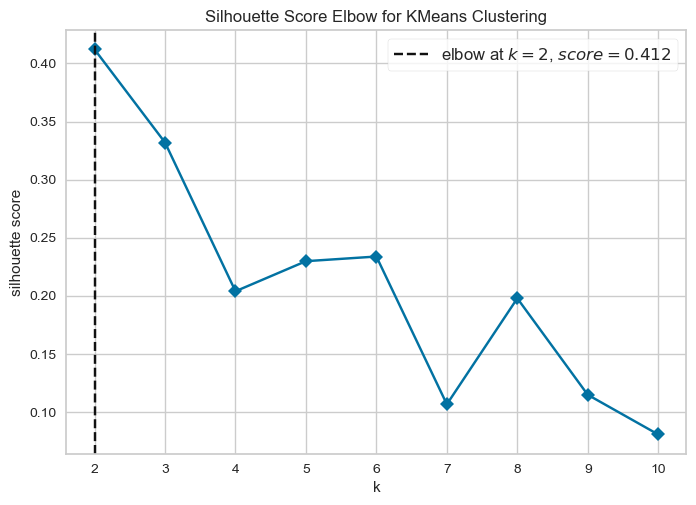

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [38]:
#setting the number of clusters
# set number of clusters
# kclusters = 6
kclusters = (2,11)

boroughs_grouped_clustering = boroughs_grouped.drop('Neighbourhood', 1)

# run k-means clustering
# kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)
model = KMeans(random_state=1)
# visualizer = KElbowVisualizer(model, k=kclusters, metric='calinski_harabasz', timings=False) # random state=0
visualizer = KElbowVisualizer(model, k=kclusters, metric='silhouette', timings=False) # random state = 0

visualizer.fit(boroughs_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()                                  # Finalize and render the figure

# check cluster labels generated for each row in the dataframe
# kmeans.labels_

- We are gonna take the value of k=4.

In [75]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=10).fit(boroughs_grouped_clustering)

#check cluster labels generated foreach row in the df
kmeans.labels_

array([2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0],
      dtype=int32)

In [76]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = pd.Series(kmeans.labels_)

boroughs_merged = boroughs_df

# merge boroughs_grouped with boroughs_df to add latitude/longitude for each neighborhood
boroughs_merged = boroughs_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

boroughs_merged.head()

,PostalCode,Borough,Neighbourhood,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,M4B,East York,Parkview Hill,43.70718,-79.31192,Coffee Shop,Bakery,Pizza Place,Gym / Fitness Center,Gastropub,Fast Food Restaurant,Office,Flea Market,Brewery,Bank,2
1,M4C,East York,Woodbine Heights,43.68970,-79.30682,Pizza Place,Coffee Shop,Grocery Store,Café,Sushi Restaurant,Baseball Field,Bus Line,Skating Rink,Ice Cream Shop,Playground,0
2,M6C,York,Humewood-Cedarvale,43.69211,-79.43036,Bagel Shop,Pizza Place,Convenience Store,Park,Grocery Store,Coffee Shop,Field,Gastropub,Metro Station,Middle Eastern Restaurant,0
3,M6E,York,Caledonia-Fairbanks,43.68784,-79.45046,Pizza Place,Japanese Restaurant,Park,ATM,Rental Service,Cosmetics Shop,Pharmacy,Seafood Restaurant,Coffee Shop,Bus Stop,2
4,M4G,East York,Leaside,43.70902,-79.36349,Sporting Goods Shop,Coffee Shop,Music Store,Electronics Store,Sports Bar,Burger Joint,Department Store,Furniture / Home Store,Restaurant,Bank,0


In [77]:
columns = [column for column in boroughs_merged.columns if column.endswith('Venue')]
columns = ['Borough', 'Neighbourhood', 'Cluster Labels'] + columns
boroughs_merged[columns]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East York,Parkview Hill,2,Coffee Shop,Bakery,Pizza Place,Gym / Fitness Center,Gastropub,Fast Food Restaurant,Office,Flea Market,Brewery,Bank
1,East York,Woodbine Heights,0,Pizza Place,Coffee Shop,Grocery Store,Café,Sushi Restaurant,Baseball Field,Bus Line,Skating Rink,Ice Cream Shop,Playground
2,York,Humewood-Cedarvale,0,Bagel Shop,Pizza Place,Convenience Store,Park,Grocery Store,Coffee Shop,Field,Gastropub,Metro Station,Middle Eastern Restaurant
3,York,Caledonia-Fairbanks,2,Pizza Place,Japanese Restaurant,Park,ATM,Rental Service,Cosmetics Shop,Pharmacy,Seafood Restaurant,Coffee Shop,Bus Stop
4,East York,Leaside,0,Sporting Goods Shop,Coffee Shop,Music Store,Electronics Store,Sports Bar,Burger Joint,Department Store,Furniture / Home Store,Restaurant,Bank
5,East York,Thorncliffe Park,0,Indian Restaurant,Coffee Shop,Restaurant,Afghan Restaurant,Greek Restaurant,Turkish Restaurant,Yoga Studio,Pizza Place,Skating Rink,Curling Ice
6,East York,East Toronto,0,Coffee Shop,Café,Sandwich Place,Pizza Place,Park,Thai Restaurant,Ethiopian Restaurant,Gastropub,Beer Bar,Beer Store
7,York,Del Ray,1,Sandwich Place,Gas Station,Convenience Store,Fast Food Restaurant,Coffee Shop,Intersection,Grocery Store,Modern European Restaurant,Movie Theater,Museum
8,Central Toronto,Lawrence Park,0,Café,Bus Line,Bookstore,Restaurant,Forest,Intersection,Gym / Fitness Center,College Quad,College Gym,Coffee Shop
9,Central Toronto,Roselawn,3,Pharmacy,Skating Rink,Playground,Café,Bank,Trail,ATM,Miscellaneous Shop,Modern European Restaurant,Movie Theater


In [78]:
#visualizing the resulting the cluster

map_cluster = folium.Map(location=[latitude,longitude], zoom_start=13)

#set the color scheme for the cluster
c = ['red','blue','pink','yellow','orange']

for lat,long,poi,cluster in zip(boroughs_merged['latitude'],
                                boroughs_merged['longitude'],
                                boroughs_merged['Neighbourhood'],
                                boroughs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + 'Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,long],
        radius = 7,
        popup = label,
        color = 'black',
        fill= True,
        fill_color = c[cluster-1],
        fill_opacity=0.9).add_to(map_cluster)

map_cluster

### Examining each cluster

In [79]:
cluster_0 = boroughs_merged[boroughs_merged['Cluster Labels'] == 0]
cluster_1 = boroughs_merged[boroughs_merged['Cluster Labels'] == 1]
cluster_2 = boroughs_merged[boroughs_merged['Cluster Labels'] == 2]
cluster_3 = boroughs_merged[boroughs_merged['Cluster Labels'] == 3]

In [80]:
print(cluster_0.shape)
print(cluster_1.shape)
print(cluster_2.shape)
print(cluster_3.shape)

(14, 16)
(1, 16)
(3, 16)
(1, 16)


In [81]:
cluster_0.head()

,PostalCode,Borough,Neighbourhood,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,M4C,East York,Woodbine Heights,43.68970,-79.30682,Pizza Place,Coffee Shop,Grocery Store,Café,Sushi Restaurant,Baseball Field,Bus Line,Skating Rink,Ice Cream Shop,Playground,0
2,M6C,York,Humewood-Cedarvale,43.69211,-79.43036,Bagel Shop,Pizza Place,Convenience Store,Park,Grocery Store,Coffee Shop,Field,Gastropub,Metro Station,Middle Eastern Restaurant,0
4,M4G,East York,Leaside,43.70902,-79.36349,Sporting Goods Shop,Coffee Shop,Music Store,Electronics Store,Sports Bar,Burger Joint,Department Store,Furniture / Home Store,Restaurant,Bank,0
5,M4H,East York,Thorncliffe Park,43.70142,-79.34905,Indian Restaurant,Coffee Shop,Restaurant,Afghan Restaurant,Greek Restaurant,Turkish Restaurant,Yoga Studio,Pizza Place,Skating Rink,Curling Ice,0
6,M4J,East York,East Toronto,43.68811,-79.33418,Coffee Shop,Café,Sandwich Place,Pizza Place,Park,Thai Restaurant,Ethiopian Restaurant,Gastropub,Beer Bar,Beer Store,0


In [82]:
zero = cluster_0.groupby('2nd Most Common Venue').count()

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

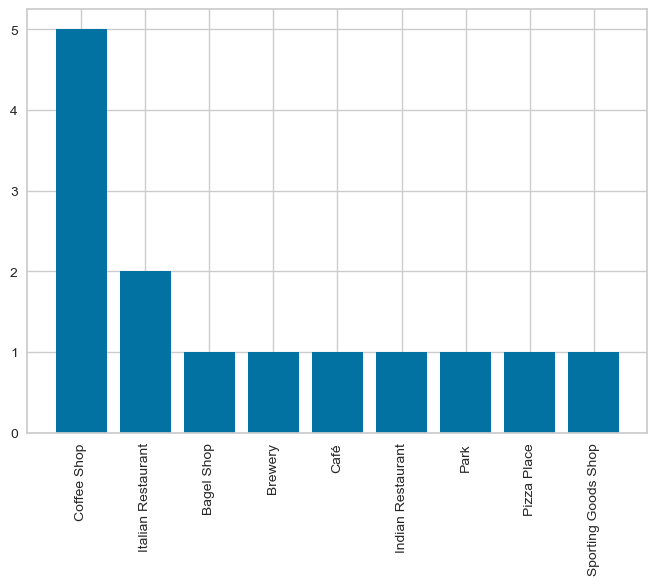

In [83]:
d = cluster_0.groupby('1st Most Common Venue')['Neighbourhood'].count().reset_index().sort_values(by='Neighbourhood',ascending=False)
plt.bar(d['1st Most Common Venue'],d['Neighbourhood'])
plt.xticks(rotation=90)

In [84]:
cluster_0.groupby('3rd Most Common Venue')['Neighbourhood'].count().reset_index().sort_values(by='Neighbourhood',ascending=False)

,3rd Most Common Venue,Neighbourhood
1,Café,2
6,Italian Restaurant,2
0,Bookstore,1
2,Coffee Shop,1
3,Convenience Store,1
4,Department Store,1
5,Grocery Store,1
7,Music Store,1
8,Park,1
9,Pizza Place,1


- In the 0th cluster we have coffee shops more in common.

In [85]:
def cluster_venue(n_most_common_venue,cluster_df):
    cluster = cluster_df.groupby(n_most_common_venue)['Neighbourhood'].count().reset_index().sort_values(by='Neighbourhood',ascending=False)
    bar_plot = plt.bar(cluster.iloc[:,0].values,cluster['Neighbourhood'])
    plt.xticks(rotation=90)
    plt.ylabel('Neighbourhood Counts')
    plt.xlabel(n_most_common_venue)
    #plt.show()

    return bar_plot

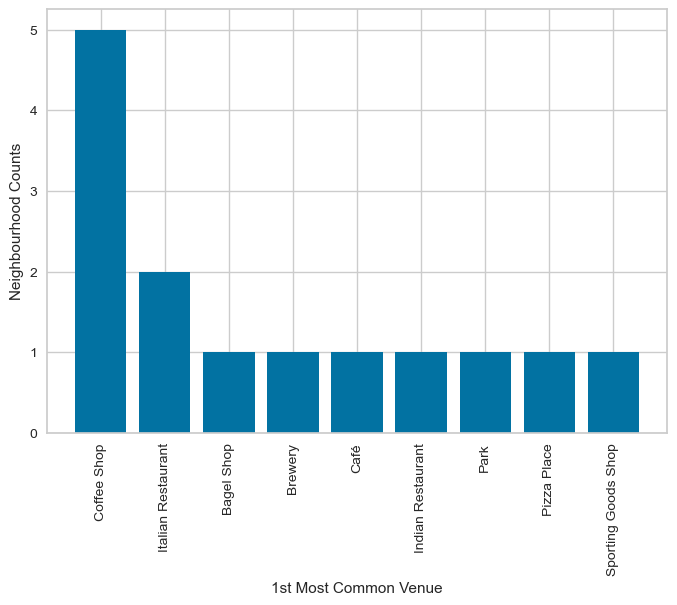

In [86]:
cluster_venue('1st Most Common Venue',cluster_0);

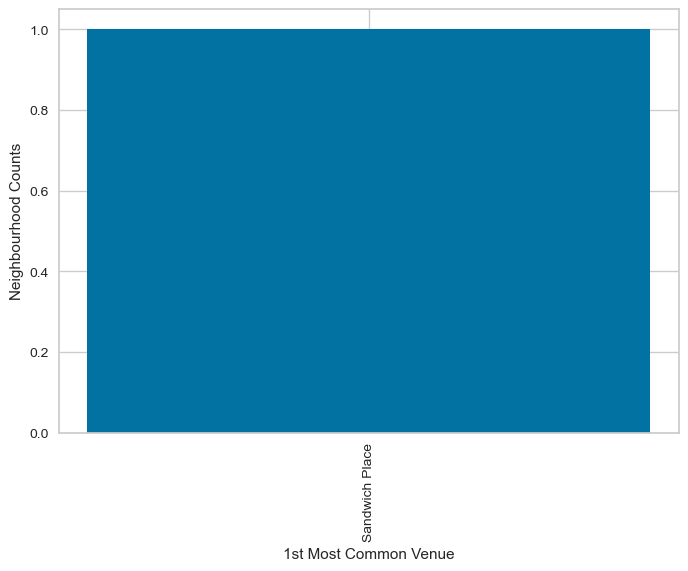

In [87]:
cluster_venue('1st Most Common Venue',cluster_1);

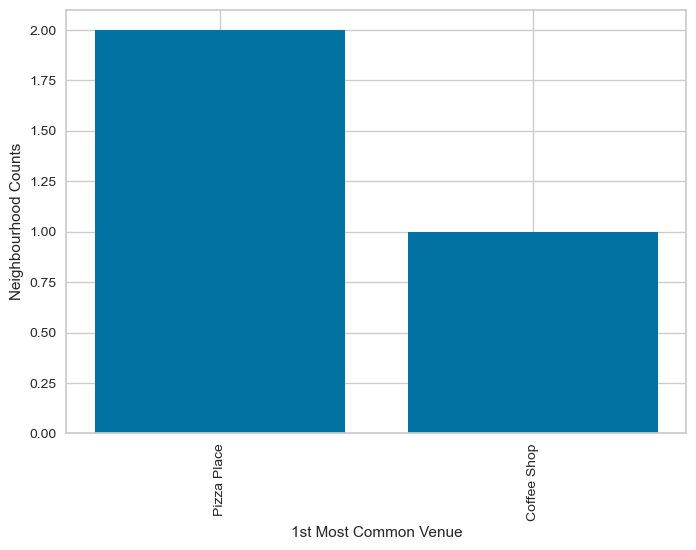

In [88]:
cluster_venue('1st Most Common Venue',cluster_2);

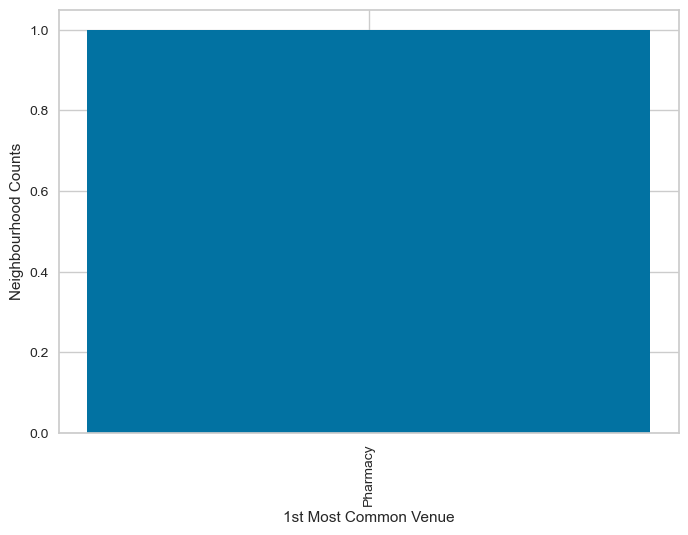

In [89]:
cluster_venue('1st Most Common Venue',cluster_3);

- We can clearly see from the graphs that:

>- <b>Cluster0</b> has most number of coffee shops.Hence better.
>- <b>Cluster1</b> has most number of sandwich places.
>- <b>Cluster2</b> has more number of Pizza places.
>- <b>Cluster3</b> has more number of pharmacies.